# I. Introduction
In this note we go through the concept of Kalman filter, the notebook is heavily inspired by lessons from [Udacity course](https://www.udacity.com/drive).

The notebook is organized as following

* Re-call on Gaussian distribution
* Kalman filter in 1D space
* 

Let's load some module

In [21]:
import numpy as np

# Load matplotib
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')  # emulates the aesthetics of ggplot (of R)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as mticker

# II. Gaussian distribution
The Gaussian distribution has following form for 1D variable

$$
\mathcal{N}(x\ |\ \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(x-\mu)^2}{2\sigma^2}\right\}
$$

where $\mu$ is the mean and $\sigma^2$ is the variance. 

For $D-$dimension, it takes the form

$$
\mathcal{N}(x\ |\ \mu,\Sigma^2) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp\left\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right\}
$$

### Conditional/Marginal Gaussian
Consider $\mathcal{N}(x\ |\ \mu,\Sigma)$ with $\Lambda=\Sigma^{-1}$ and

$$
\begin{split}
&x =\left(\begin{array}{c}x_a\\ x_b\end{array}\right),\ &\mu=\left(\begin{array}{c}\mu_a\\ \mu_b\end{array}\right)\\
&\Sigma = \left(\begin{array}{cc}\Sigma_{aa} & \Sigma_{ab}\\ \Sigma_{ba} & \Sigma_{bb}\end{array}\right),\ 
&\Lambda= \left(\begin{array}{cc}\Lambda_{aa} & \Lambda_{ab}\\ \Lambda_{ba} & \Lambda_{bb}\end{array}\right)\end{split}
$$

Then we have
* Conditional distribution
$$
\begin{split}
p(x_a|x_b) &= \mathcal{N}\left(x\ |\ \mu_{a|b},\Lambda_{aa}^{-1}\right)\\
\mu_{a|b} &= \mu_a-\Lambda_{aa}^{-1}\Lambda_{ab}(x_b - \mu_b)
\end{split}
$$
* Marginal distribution
$$
p(x_a) = \mathcal{N}\left(x_a\ |\ \mu_a, \Sigma_{aa}\right)
$$

### Bayes' theorem for Gaussian variables
We recall Bayes' theorem
$$
\begin{split}
\mathbb{P}(X,Y) = \mathbb{P}(X\ |\ Y)\mathbb{P}(Y)=\mathbb{P}(Y\ |\ X)\mathbb{P}(X)\\
\end{split}
$$

Given the prior and conditional distribution (linear Gaussian model)
$$
\begin{split}
p(x) &= \mathcal{N}\left(x\ |\ \mu,\Lambda^{-1}\right)\\
p(y\ |\ x) &= \mathcal{N}\left(y\ |\ Ax + b, L^{-1}\right)
\end{split}
$$
One can apply Bayes' theorem to find the marginal distribution $p(y)$ and the conditional distribution (also called posteriori) distribution $p(x\ |\ y)$.

We have (proof can be found in chapter 2 in Bishop's book)
$$
\begin{split}
p(y)   &= \mathcal{N}\left(y\ |\ A\mu+b,L^{-1} + A\Lambda^{-1}A^T\right)\\
p(x|y) &= \mathcal{N}\left(x\ |\ \Sigma\left\{A^TL(y-b) + \Lambda\mu\right\}, \Sigma\right)
\end{split}
$$
where
$$
\Sigma=\left(\Lambda + A^TLA\right)^{-1}
$$

# III. Kalman filter
The [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter) is an algorithm to estimate current state by iterating on two main cycles: mesurement update/motion update (also called update step/prediction step)

* **Measurement update**: given a measurement, we update the distribution of the current state
* **Motion update**: given a physical update (e.g move forward 10m), we predict the distribution of the next state

Let's go through some example (taken for Udacity course), consider a robot and a line of 5 squares (each is either green or red) as the following image

![robot_loc](assets/kalman_locs.png)

The robot can be in any square with uniform probability 0.2, denote $X$ as our robot's the location

$$
P(X=i) = 0.2
$$

We know that our robot can sense its location's color, denote $Y$ as the sensed color, we have $Y\in\left\{\text{red, green}\right\}$

### Measurement update
Now, if the robot sensed the color red $Y=\text{red}$, what is the distribution of robot's location i.e 
$$
P(X=i\ |\ Y=\text{red}) = ?
$$
By applying Bayes' rule, the distribution of robot's location becomes
$$
P(X=i\ |\ Y=\text{red}) = \left\{ \begin{array}{l}
                                    0.5 \text{ for } i=2,3 \\
                                    0 \text{ otherwise}
                                  \end{array}\right.
$$
So with an additional info (color sensing), we know more precise about our robot's location. This is the **Measurement update** step.

### Motion update
Now, let's our robot to move one step to the right, given previous step's distribution we know that
$$
P(X=i) = \left\{ \begin{array}{l}
                  0.5 \text{ for } i=3,4 \\
                  0 \text{ otherwise}
                  \end{array}\right.
$$
If we sense the color **red** again, applying another **Measurement update** then we know for sure that our robot's current location must be 3.

So we go through an example where robot's location is discrete and measurement/motion update is perfect (no noise). The Kalman filter is much more powerful and it can handle 

* state is continuous (1D or multi-dimensional)
* measurement can have Gaussian noise
* motion update can have Gaussian noise

Let's dive into 1D-case
### 1D Kalman filter
Now we consider a car that drives on a straight line with constant speed $v$ and we denote 

* $x_t$ is the real position of the car at time $t$ (which we don't know exactly) and 
* $y_t$ is position obtained via GPS (which might have small errror/noise)

We also assume the initial location $x_0\sim\mathcal{N}(\mu_0, \sigma_0^2)$, and all noise/error is of Gaussian distribution i.e
$$
\begin{split}
y_t &= x_t + \epsilon,&\quad \epsilon\sim\mathcal{N}(0, \theta^2)\\
x_t &= x_{t-1} + v + \xi,&\quad \xi \sim\mathcal{N}(0, \sigma^2)
\end{split}
$$

The goal is to estimate $x_t$ given observed $y_t$. Since the noise/error are random, we can only estimate the distribution of $x_t$ i.e
$$
\mathbb{P}(x_t\ |\ y_t)
$$
This is done in two steps, suppose we have from previous step $x_{t-1}\sim\mathcal{N}(\mu_{t-1}, \sigma_{t-1}^2)$
* Motion update
$$
x_t = x_{t-1} + v + \xi \sim \mathcal{N}(x_t \ |\ \mu_{t-1} + v, \sigma_{t-1}^2 + \sigma^2)
$$
we denote $\sigma_{t,\ t-1}^2= \sigma_{t-1}^2 + \sigma^2$ and $\mu_{t,t-1}=\mu_{t-1} + v$
* Measurement update, we know that
$$
p(y_t\ |\ x_t) \sim \mathcal{N}(y_t\ |\ x_t, \theta^2)
$$

So we have
$$
\begin{split}
p(x_t) & \sim \mathcal{N}(x_t \ |\ \mu_{t,t-1}, \sigma_{t,t-1}^2)\\
p(y_t\ |\ x_t) & \sim \mathcal{N}(y_t \ |\ x_t, \theta^2)
\end{split}
$$
Applying Bayes' theorem for Gaussian with $A=\mathbb{Id}, b=0$, we obtain
$$
\begin{split}
p(y_t) &\sim \mathcal{N}(y_t \ |\ \mu_{t,t-1}, \sigma_{t,t-1}^2 + \theta^2)\\
p(x_t\ |\ y_t) &\sim \mathcal{N}(x_t \ |\ \Sigma\left\{Ly_t+\Lambda \mu_{t,t-1}\right\}, \Sigma)
\end{split}
$$
with 
$$\begin{split}
L&=\frac{1}{\theta^2}\\
\Lambda&=\frac{1}{\sigma_{t,t-1}^2}\\
\Sigma&= \frac{1}{L + \Lambda}
\end{split}
$$

Combining the two above steps, we obtain the Kalman filtering for 1D

$$\begin{split}
\mu_{t,t-1}&=\mu_{t-1} + v\\
\sigma_{t,\ t-1}^2&= \sigma_{t-1}^2 + \sigma^2\\
L &= \theta^{-2}\\
\Lambda &= \sigma_{t,t-1}^{-2}\\
\Sigma &= \left(\Lambda  + L\right)^{-1}\\
\mu_t &= \Sigma\left\{Ly_t + \Lambda \mu_{t, t-1}\right)\\
\sigma_t^2&= \Sigma
\end{split}
$$

Now let's code it up 

In [60]:
def predict(mean1, var1, mean_speed, var_speed):
    '''
    motion update step
        mean1: mean previous state mu_{t-1}
        var1:  var previous state sigma_{t-1}^2
    return [mu_{t,t-1}, sigma_{t,t-1}^2]
    '''
    return [mean1 + mean_speed, var1 + var_speed]

def update(mean1, var1, measure, var_measure):
    '''
    measure update step
        mean1:       mu_{t,t-1}
        var1:        sigma_{t,t-1}^2
        measure:     y_t
        var_measure: theta^2
    return [mu_t, sigma_t^2]
    '''
    new_mean = (var1 * measure + var_measure * mean1) / (var1 + var_measure)
    new_var  = 1. / (1./var1 + 1./var_measure)
    return [new_mean, new_var]

def kalman1d(mu0, sig0, 
             mean_speed, var_speed,
             measurements, var_measurement,
             verbose = False):
    '''
    running Kalman-filtering
        mu0, sig0: initial distribution
        mean_speed, var_speed: motion update speed & noise
        measurements, var_measurement: measurements & noise 
                        including measurement for initial step
    '''
    mu, sig = mu0, sig0
    sigmas = [sig]
    mus = [mu]
    for i in range(len(measurements)):
        # update after measurement
        mu, sig = update(mu, sig, measurements[i], var_measurement)
        mus.append(mu)
        sigmas.append(sig)
        if verbose:
            print('update:  {}'.format([mu, sig]))
        # predict next state
        mu, sig = predict(mu, sig, mean_speed, var_speed)
        if verbose:
            print('predict: {}'.format([mu, sig]))
    
    print('\nfinal mean/var {:.2f}/{:.2f}'.format(mu, sig))
    return np.array(mus), np.array(sigmas)

def bivar_gauss_contour(mu1, mu2, sig1, sig2, rho, f_ax=None):
    '''
    this function draw contour for bivariate gausian distribution
    '''
    sig1 = np.sqrt(sig1)
    sig2 = np.sqrt(sig2)
    sig12 = rho*sig1*sig2
    delta = 0.025
    x = np.arange(mu1 - 2.*sig1, mu1 + 2.*sig1, delta)
    y = np.arange(mu2 - 2.*sig2, mu2 + 2.*sig2, delta)
    
    X, Y = np.meshgrid(x, y)
    Z = mlab.bivariate_normal(X, Y, sigmax=sig1, sigmay=sig2, mux=mu1, muy=mu2, sigmaxy=sig12)
    if f_ax is None:
        f, ax = plt.subplots()
    else:
        f, ax = f_ax
    ax.contour(X, Y, Z)
    ax.set_xlabel('x')
    ax.set_ylabel('$\dot{x}$')
    ax.set_xlim([min(mu1 - 2.*sig1, mu2 - 2.*sig2), max(mu1 + 2.*sig1, mu2 + 2.*sig2)])
    
    return f,ax

Let's try this out


final mean/var 100.00/1.62


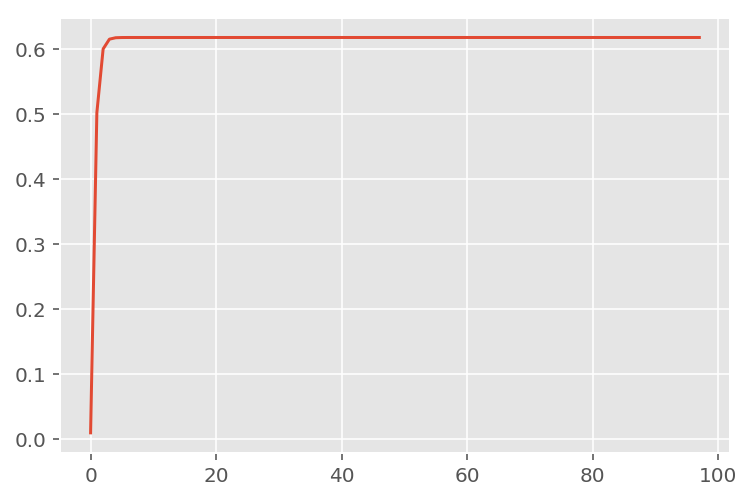

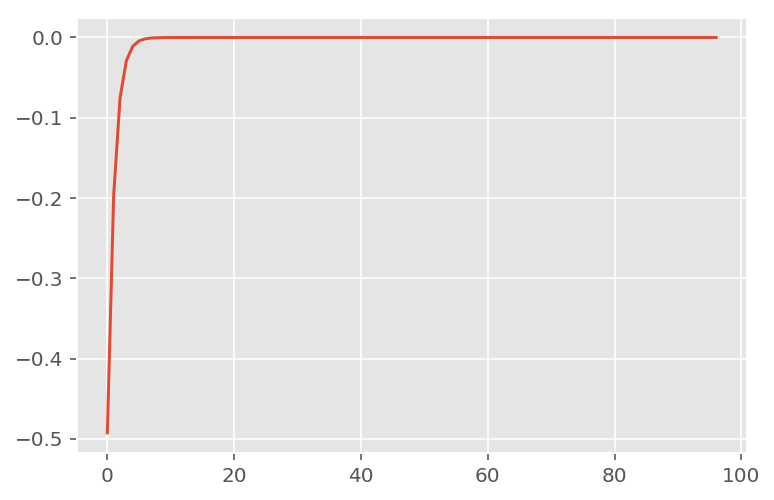

In [3]:
# initial distribution
mu0  = 1.
sig0 = 0.01

# motion update mean/noise
v = 1.
sigma = 1.

# measurement value/noise
y = np.arange(2., 100.)
theta = 1.
mus, sigmas = kalman1d(mu0, sig0, v, sigma, y, theta, False)
_ = plt.plot(range(len(sigmas[1:])), sigmas[1:])
plt.figure()
errs = mus[1:] - y
_ = plt.plot(range(len(errs[1:])), errs[1:])

We notice that

* the variance after measurement is smaller than the measurement noise and it converges to a constant independent of initial $\sigma_0$
* the error between estimated $\mu_t$  and $y_t$ converges to zero independent of initial $\mu_0$ 

the above properties makes Kalman filtering very powerful to estimate current state given measurement: **the more measurements, the more precise estimation** independent of initial steps.

### Kalman filter in D-dimension
Before discussing Kalman filter in D-dimension, we look at the following 2D example 

* estimation our car's **position and velocity**
* we only observe car's **position**

At initial step $t=0$, suppose we know the car's position $x$ is around 0 but not its velocity $\dot{x}$, this can be represented as
$$
\left(\begin{array}{c}x_t\\ \dot{x}_t\end{array}\right)_{t=0}\sim \mathcal{N}\left(\left(\begin{array}{c}0\\
0\end{array}\right), \left(\begin{array}{cc}0.01 & 0\\
0 & 1\end{array}\right)\right)
$$
which means

* the variance of position is low means the position is well estimated
* the variance of velocity is quite high since we haven't observe the velocity yet
* the two measurements aren't correlated (since we know nothing about velocity)

The distribution's contour is visualized below

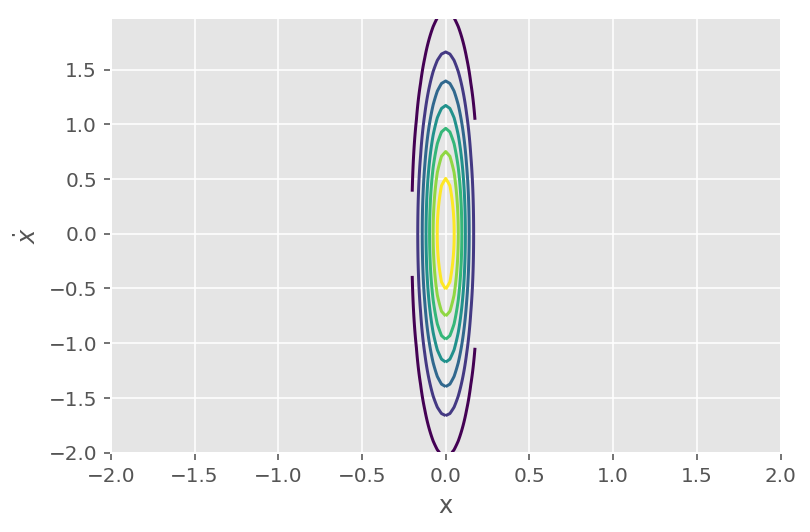

In [59]:
_ = bivar_gauss_contour(0.0, 0.0, 0.01, 1.0, 0.)

Now, at **prediction step** for $t=1$, we know that 
$$
x_{t=1} = x_{t=0} + \dot{x}_{t=0}
$$
so given $x_{t=0}$, we have $x_{t=1}$ and $\dot{x}_{t=0}$ are closely correlated, this can be represented as

$$
\left(\begin{array}{c}x_t\\ \dot{x}_t\end{array}\right)_{t=1}\ |\ x_{t=0}\sim \mathcal{N}\left(\left(\begin{array}{c}0\\
0\end{array}\right), \left(\begin{array}{cc}1.01 & 1.0\\
1.0 & 1\end{array}\right)\right)
$$
We obtain the following visualization

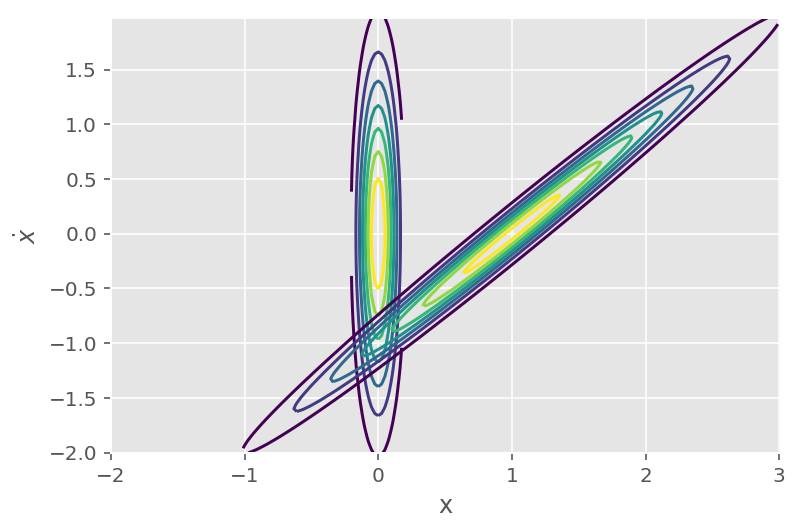

In [63]:
fig,ax = bivar_gauss_contour(0.0, 0.0,  0.01, 1.0, .0)
_ = bivar_gauss_contour(1.0, 0.0, 1.01, 1.0,  0.99, (fig, ax))

Looking at the second distribution, we know that if we observe the position $x_{t=1}$, we can infer the velocity quite precisely. This is the insight of how Kalman fiter **estimating hidden/unobservable state** (in this example it's the car's velocity).

Now we are ready to checkout the Kalman filter for D-dimension, first we define some notation

* $x_t$: state at time $t$
* $u_t$: motion input at time $t$
* $w_t$: motion-update noise which is assumed to be a normal distribution with zero-mean
* $F_t$: state-transition matrix which applied to previous state $x_{t-1}$
* $B_t$: motion control which applied to motion input $u_t$
* $H_t$: observation model
* $z_t$: an measurement at time $t$ 
* $v_t$: measurement noise which is assumed to be a normal distribution with zero-mean

The Kalman assumes the state/observation is evolved according to the following dynamics

$$
\begin{split}
x_t &= F_t \times x_{t-1} + B_t \times u_{t} + w_t\\
z_t &= H_t \times x_t + v_t\\
w_t &\sim \mathcal{N}\left(0,Q_t\right)\\
v_t &\sim \mathcal{N}\left(0,R_t\right)\\
\end{split}
$$

We have then the *update/predict* steps given below

* **Predict**: 
$$
\begin{array}{lll}
\text{priori state estimation}  & \hat{x}_{t\ |\ t-1}&= F_t \times \hat{x}_{t-1\ |\ t-1} + B_t\times u_t\\
\text{priori state covariance} & P_{t\ |\ t-1}&= F_t\times P_{t-1\ |\ t-1} \times F_t^T + Q_t
\end{array}
$$

* **Update**:
$$
\begin{array}{lll}
\text{pre-fit residual}  & \tilde{y}_{t}&= z_t - H_t\times \hat{x}_{t\ |\ t-1}\\
\text{pre-fit residual-covariance} &S_t &= R_t + H_t\times P_{t\ |\ t-1} \times H_t^T\\
\text{Kalman gain} & K_t &= P_{t\ |\ t-1} \times H_t^T \times S_t^{-1}\\
\text{posteriori state estimation} & \hat{x}_{t\ |\ t} &= \hat{x}_{t\ |\ t-1} + K_t\times \tilde{y}_{t}\\
\text{posteriori state covariance} & P_{t\ |\ t} &= \left(I-K_t\times H_t\right)\times P_{t\ |\ t-1}\\
\text{post-fit residual} & \hat{y}_{t\ |\ t} &= z_{t} - H_t\times \hat{x}_{t\ |\ t}
\end{array}
$$

The following block implements Kalman filter for D-dimension case (taken from Udacity)

In [66]:
from math import *


class matrix:
    
    # implements basic operations of a matrix class
    
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0])
        if value == [[]]:
            self.dimx = 0
    
    def zero(self, dimx, dimy):
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx = dimx
            self.dimy = dimy
            self.value = [[0 for row in range(dimy)] for col in range(dimx)]
    
    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx = dim
            self.dimy = dim
            self.value = [[0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1
    
    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')
    
    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to add")
        else:
            # add if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res
    
    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to subtract")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res
    
    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
            return res
    
    def transpose(self):
        # compute transpose
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res
    
    # Thanks to Ernesto P. Adorio for use of Cholesky and CholeskyInverse functions
    
    def Cholesky(self, ztol=1.0e-5):
        # Computes the upper triangular Cholesky factorization of
        # a positive definite matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(self.dimx)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res
    
    def CholeskyInverse(self):
        # Computes inverse of matrix given its Cholesky upper Triangular
        # decomposition of matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/tjj**2 - S/tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = -sum([self.value[i][k]*res.value[k][j] for k in range(i+1, self.dimx)])/self.value[i][i]
        return res
    
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res
    
    def __repr__(self):
        return repr(self.value)


In [73]:
def kalman_filter(x, P):
    for n in range(len(measurements)):
        
        # measurement update
        z = matrix([[measurements[n]]])
        y = z - (H*x)
        Ht = H.transpose()
        S = H*P*Ht + R
        K = P*Ht*S.inverse()
        x = x + K*y
        P = (I - (K*H)) * P

        # prediction
        x = (F*x) + u
        P = F*P*F.transpose()
        
    return x,P
    
measurements = [1, 2, 3]

x = matrix([[0.], [0.]]) # initial state (location and velocity)
P = matrix([[1000., 0.], [0., 1000.]]) # initial uncertainty
u = matrix([[0.], [0.]]) # external motion
F = matrix([[1., 1.], [0, 1.]]) # next state function
H = matrix([[1., 0.]]) # measurement function
R = matrix([[1.]]) # measurement uncertainty
I = matrix([[1., 0.], [0., 1.]]) # identity matrix

x,P = kalman_filter(x, P)
print(x)
print(P)

[[3.9996664447958645], [0.9999998335552873]]
[[2.3318904241194827, 0.9991676099921091], [0.9991676099921067, 0.49950058263974184]]


Look at the above method, we can see that from only position measurement, we can estimate the velocity ~ 1.0 which is quite amazing.

This Kalman filtering technique is used in *self driving car* to **estimate other car's velocity** i.e

* From lasers and radar, we obtain the location of other cars with respect to our car 
* Using Kalman filtering, we can estimate velocity of other cars using our location and other cars' location.